In [1]:
import pandas as pd
import torch
import sklearn
import numpy as np

import transformers

c:\Users\robin\anaconda3\envs\dnabert\lib\site-packages\tqdm\auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


In [2]:
# If there's a GPU available...
if torch.cuda.is_available():    

    # Tell PyTorch to use the GPU.    
    device = torch.device("cuda")

    print('There are %d GPU(s) available.' % torch.cuda.device_count())

    print('We will use the GPU:', torch.cuda.get_device_name(0))

# If not...
else:
    print('No GPU available, using the CPU instead.')
    device = torch.device("cpu")


There are 1 GPU(s) available.
We will use the GPU: NVIDIA GeForce GTX 1050 with Max-Q Design


In [3]:
modelpath = "zhihan1996/DNABERT-2-117M"
df = pd.read_csv("./sample_data/esp_decoded.csv")

print(df.info())

print(df.head())

sequences = df['seq']
labels = df['y']

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 56888 entries, 0 to 56887
Data columns (total 2 columns):
 #   Column  Non-Null Count  Dtype  
---  ------  --------------  -----  
 0   seq     56888 non-null  object 
 1   y       56888 non-null  float64
dtypes: float64(1), object(1)
memory usage: 889.0+ KB
None
                     seq         y
0  AAAAAAAAACTCCAAAACCCT  0.093147
1  AAAAAACAACAAGAAGCACAA  0.064951
2  AAAAAACACAAGCAAGACCGT  0.061797
3  AAAAAACAGATGCCACCTGTG  0.057246
4  AAAAAACCCGTAGATAGCCTC  0.067596


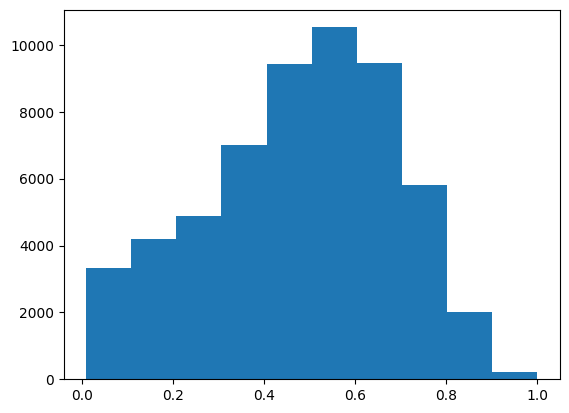

In [4]:
import matplotlib.pyplot as plt

#plot label distribution
plt.hist(labels)
plt.show()

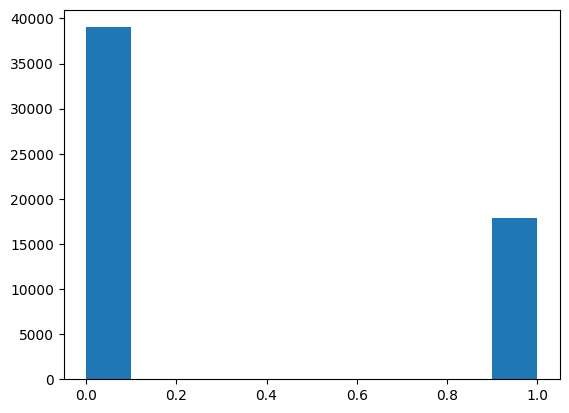

In [5]:
# change y into 1 and 0 so we can use it for binary classification
# y < 0.60 = 0 (not a good sequence)
# y >= 0.60 = 1 (good sequence)

labels = [1 if y >= 0.60 else 0 for y in labels]

plt.hist(labels)
plt.show()

In [6]:
tokenizer = transformers.AutoTokenizer.from_pretrained(
        modelpath,
        
        model_max_length=100,
        padding_side="right",
        use_fast=True,
        trust_remote_code=True,
    )

In [11]:
#sequences = sequences.tolist()

output = tokenizer(
        sequences,
        return_tensors="pt",
        padding="longest",
        max_length=tokenizer.model_max_length,
        truncation=True,
    )

import datasets

#turn df into a dataset
tokenized = datasets.Dataset.from_dict(output)



# padded = torch.nn.utils.rnn.pad_sequence(
#         output['input_ids'], batch_first=True, padding_value=tokenizer.pad_token_id
#     )

input_ids = output['input_ids']
attention_masks = output['attention_mask']

#Convert labels to tensors
labels = torch.Tensor(labels).long()

print('Original: ', sequences[:2])
print('Token IDs:', input_ids[:2])
print('Attention Mask:', attention_masks[:2])

print(type(input_ids))
print(type(attention_masks))
print(type(labels))


Original:  ['AAAAAAAAACTCCAAAACCCT', 'AAAAAACAACAAGAAGCACAA']
Token IDs: tensor([[   1,  750, 2890,   13, 1038,    2,    3,    3,    3,    3],
        [   1,  142,  361,  706,   27,    2,    3,    3,    3,    3]])
Attention Mask: tensor([[1, 1, 1, 1, 1, 1, 0, 0, 0, 0],
        [1, 1, 1, 1, 1, 1, 0, 0, 0, 0]])
<class 'torch.Tensor'>
<class 'torch.Tensor'>
<class 'torch.Tensor'>


In [23]:
print(tokenized)
print(type(tokenized))


print(type(tokenized['input_ids']))

tokenized.set_format("torch")


print(tokenized)
print(type(tokenized))


print(type(tokenized['input_ids']))
print(tokenized['input_ids'][0].shape)

Dataset({
    features: ['input_ids', 'token_type_ids', 'attention_mask'],
    num_rows: 56888
})
<class 'datasets.arrow_dataset.Dataset'>
<class 'torch.Tensor'>
Dataset({
    features: ['input_ids', 'token_type_ids', 'attention_mask'],
    num_rows: 56888
})
<class 'datasets.arrow_dataset.Dataset'>
<class 'torch.Tensor'>
torch.Size([10])


In [25]:
#Check if padding works
pos_shapes = []

for i in range(len(tokenized['input_ids'])):
    if(pos_shapes.__contains__(tokenized['input_ids'][i].shape)):
        continue
    else:
        pos_shapes.append(tokenized['input_ids'][i].shape)

print(pos_shapes)

[torch.Size([10])]


KeyboardInterrupt: 

In [9]:
from torch.utils.data import TensorDataset, random_split

# Combine the training inputs into a TensorDataset.
dataset = TensorDataset(input_ids, attention_masks, labels)

# Create a 90-10 train-validation split.

# Calculate the number of samples to include in each set.
train_size = int(0.9 * len(dataset))
val_size = len(dataset) - train_size

# Divide the dataset by randomly selecting samples.
train_dataset, val_dataset = random_split(dataset, [train_size, val_size])

print('{:>5,} training samples'.format(train_size))
print('{:>5,} validation samples'.format(val_size))


print(train_dataset[0])

51,199 training samples
5,689 validation samples
(tensor([   1,  553, 1413,  135,  192,    2,    3,    3,    3,    3]), tensor([1, 1, 1, 1, 1, 1, 0, 0, 0, 0]), tensor(0))


In [10]:
from torch.utils.data import DataLoader, RandomSampler, SequentialSampler

# The DataLoader needs to know our batch size for training, so we specify it 
# here. For fine-tuning BERT on a specific task, the authors recommend a batch 
# size of 16 or 32.
batch_size = 8

# Create the DataLoaders for our training and validation sets.
# We'll take training samples in random order. 
train_dataloader = DataLoader(
            train_dataset,  # The training samples.
            sampler = RandomSampler(train_dataset), # Select batches randomly
            batch_size = batch_size # Trains with this batch size.
        )

# For validation the order doesn't matter, so we'll just read them sequentially.
validation_dataloader = DataLoader(
            val_dataset, # The validation samples.
            sampler = SequentialSampler(val_dataset), # Pull out batches sequentially.
            batch_size = batch_size # Evaluate with this batch size.
        )


# for batch in train_dataloader:
#     print(batch)
#     break

In [11]:
# load model
model = transformers.AutoModelForSequenceClassification.from_pretrained(
    modelpath,
    cache_dir=None,
    num_labels=2,
    trust_remote_code=True,
)

model.cuda()

C:\Users\robin/.cache\huggingface\modules\transformers_modules\zhihan1996\DNABERT-2-117M\1d020b803b871a976f5f3d5565f0eac8f2c7bb81\bert_layers.py:125: UserWarning: Unable to import Triton; defaulting MosaicBERT attention implementation to pytorch (this will reduce throughput when using this model).
  warnings.warn(
Some weights of the model checkpoint at zhihan1996/DNABERT-2-117M were not used when initializing BertForSequenceClassification: ['cls.predictions.transform.LayerNorm.bias', 'cls.predictions.decoder.bias', 'cls.predictions.transform.dense.bias', 'cls.predictions.transform.dense.weight', 'cls.predictions.transform.LayerNorm.weight', 'cls.predictions.decoder.weight']
- This IS expected if you are initializing BertForSequenceClassification from the checkpoint of a model trained on another task or with another architecture (e.g. initializing a BertForSequenceClassification model from a BertForPreTraining model).
- This IS NOT expected if you are initializing BertForSequenceClassi

BertForSequenceClassification(
  (bert): BertModel(
    (embeddings): BertEmbeddings(
      (word_embeddings): Embedding(4096, 768, padding_idx=0)
      (token_type_embeddings): Embedding(2, 768)
      (LayerNorm): LayerNorm((768,), eps=1e-12, elementwise_affine=True)
      (dropout): Dropout(p=0.1, inplace=False)
    )
    (encoder): BertEncoder(
      (layer): ModuleList(
        (0-11): 12 x BertLayer(
          (attention): BertUnpadAttention(
            (self): BertUnpadSelfAttention(
              (dropout): Dropout(p=0.0, inplace=False)
              (Wqkv): Linear(in_features=768, out_features=2304, bias=True)
            )
            (output): BertSelfOutput(
              (dense): Linear(in_features=768, out_features=768, bias=True)
              (LayerNorm): LayerNorm((768,), eps=1e-12, elementwise_affine=True)
              (dropout): Dropout(p=0.1, inplace=False)
            )
          )
          (mlp): BertGatedLinearUnitMLP(
            (gated_layers): Linear(in_feat

In [12]:
from transformers import AdamW

optimizer = AdamW(model.parameters(),
                  lr = 2e-5,
                  eps = 1e-8
                )

c:\Users\robin\anaconda3\envs\dnabert\lib\site-packages\transformers\optimization.py:407: FutureWarning: This implementation of AdamW is deprecated and will be removed in a future version. Use the PyTorch implementation torch.optim.AdamW instead, or set `no_deprecation_warning=True` to disable this warning
  warnings.warn(


In [13]:
for batch in train_dataloader:
    print(batch)
    break

[tensor([[   1,    5, 3440,   45,  507,   72,    2,    3,    3,    3],
        [   1,    5,  231,  725,  104, 3131,    2,    3,    3,    3],
        [   1,  229, 2465,  332,   25,    2,    3,    3,    3,    3],
        [   1,   66,   83,  245,  123,   42,    2,    3,    3,    3],
        [   1, 3242,  114,   22,  359,   40,    2,    3,    3,    3],
        [   1,    5,   83,  135,  103,  173, 1049,    2,    3,    3],
        [   1,  229,  104, 1700,  330,    6,    2,    3,    3,    3],
        [   1,  317,   73,   13,  962,   19,    7,    2,    3,    3]]), tensor([[1, 1, 1, 1, 1, 1, 1, 0, 0, 0],
        [1, 1, 1, 1, 1, 1, 1, 0, 0, 0],
        [1, 1, 1, 1, 1, 1, 0, 0, 0, 0],
        [1, 1, 1, 1, 1, 1, 1, 0, 0, 0],
        [1, 1, 1, 1, 1, 1, 1, 0, 0, 0],
        [1, 1, 1, 1, 1, 1, 1, 1, 0, 0],
        [1, 1, 1, 1, 1, 1, 1, 0, 0, 0],
        [1, 1, 1, 1, 1, 1, 1, 1, 0, 0]]), tensor([0, 1, 0, 0, 0, 0, 0, 0])]


In [15]:
outputs = model(batch)
print(outputs.loss, outputs.logits.shape)

TypeError: ones_like(): argument 'input' (position 1) must be Tensor, not list